# Image Loading and Preprocessing

In [1]:
from __future__ import division
%matplotlib inline
import skimage
import skimage.io as io
import skimage.transform 
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

/Users/mohammedayaz/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/mohammedayaz/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Load an Image

You can load the image from a location or from an URL. For Round 1 of this tutorial, try a local image.

In [2]:
IMAGE_LOCATION = 'images/dog_sitting.jpg'

## Color Issues

When you load images from smartphone cameras that you may run into color formatting issues. You need to flip between RGB and BGR can impact an image. If **you dont have the right format** then, this would obviously throw off detection in your model. Make sure the image data you're passing around is what you think it is!

In [3]:
img = skimage.io.imread(IMAGE_LOCATION)
img = skimage.img_as_float(img).astype(np.float32)

Text(0.5,1,'Original image = RGB')

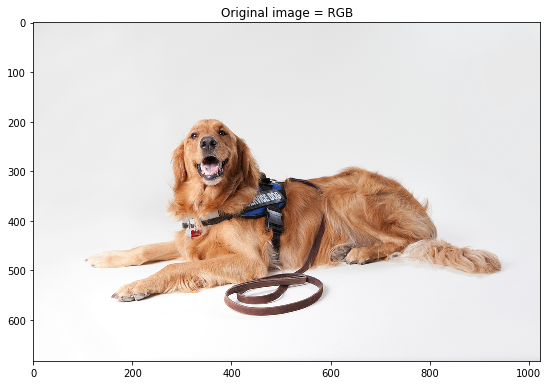

In [4]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('on')
plt.title('Original image = RGB')

### Caffe Uses BGR Order

Due to legacy support of OpenCV in Caffe and how it handles images in Blue-Green-Red (BGR) order instead of the more commonly used Red-Green-Blue (RGB) order, Caffe2 also expects **BGR** order.

The image in **BGR** - just doing **RGB->BGR** - Notice the difference 

Text(0.5,1,'OpenCV, Caffe2 = BGR')

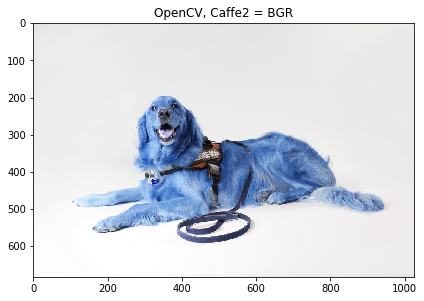

In [5]:
imgBGR = img[:, :, (2, 1, 0)]
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.imshow(imgBGR)
plt.axis('on')
plt.title('OpenCV, Caffe2 = BGR')

### Caffe Prefers CHW Order


- H: Height
- W: Width
- C: Channel (as in color)

Digging even deeper into how image data can be stored is the memory allocation order. We can transform image as if it were a cube. What we see is on top of the cube, and manipulating the layers below can change what we view. We can tinker with it's underlying properties and as you saw above, swap colors quite easily. 

For **GPU processing**, which is what Caffe2 excels at, this **order needs to be CHW**. For **CPU processing**, this **order is generally HWC**. Essentially, you're going to want to use CHW and make sure that step is included in your image pipeline. Tweak RGB to be BGR, which is encapsulated as this "C" payload, then tweak HWC, the "C" being the very same colors you just switched around.

## Rotation and Mirroring
 
We still need to **resize and/or crop** and potentially look at things like **orientation (rotation) and mirroring**.

Phones, in general, take great pictures, but do a horrible job communicating how the image was taken and what orientation it should be in. **Everything is covered under the hood and user has no control over the details of image how image is store.** 

Cameras - because there are often two cameras and these two cameras take different sized pictures in both pixel count and aspect ratio, and not only that, they sometimes take them mirrored, and they sometimes take them in portrait and landscape modes, and sometimes they don't bother to tell which mode they were in. 

Since, **the caffe2 is for mobile development**, you need to to take into account of a lot things into when developing for Android as it has a diverse market with it's hardware combination.

Image came in sideways, it should be a portait image -  How you detect this depends on the platform Could be a flag from the camera object 

In [6]:
ROTATED_IMAGE = "images/car.jpg"
imgRotated = skimage.io.imread(ROTATED_IMAGE)
imgRotated = skimage.img_as_float(imgRotated).astype(np.float32)

Text(0.5,1,'Rotated image')

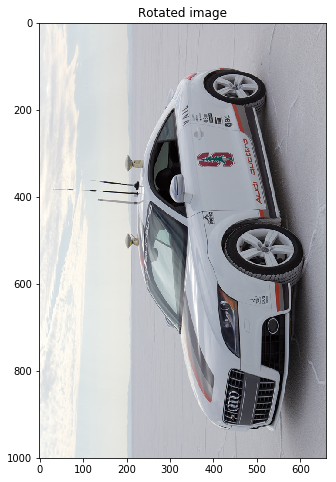

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(imgRotated)
plt.axis('on')
plt.title('Rotated image')

Image came in **flipped or mirrored - text is backwards!** Again detection depends on the platform. This one is intended to be read by drivers in their rear-view mirror

Text(0.5,1,'Corrected image')

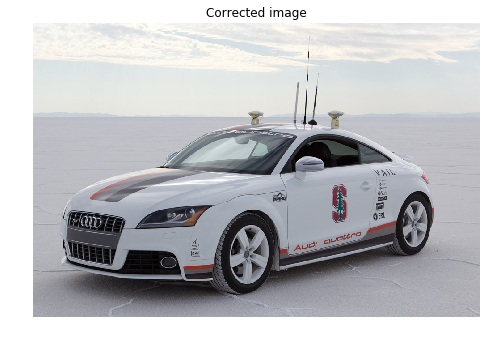

In [8]:
imgRotated = np.rot90(imgRotated, 3)
plt.figure(figsize=(8,8))
plt.imshow(imgRotated)
plt.axis('off')
plt.title('Corrected image')

Text(0.5,1,'Mirror image')

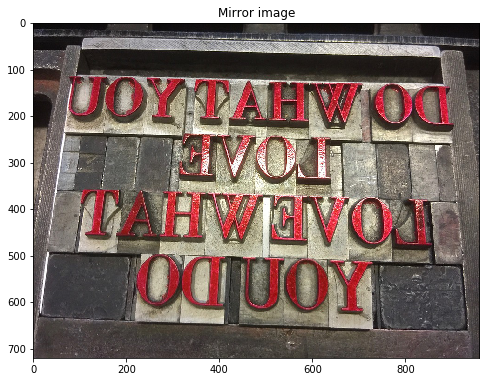

In [9]:
MIRROR_IMAGE = "images/book-mirrored.jpg"
imgMirror = skimage.img_as_float(skimage.io.imread(MIRROR_IMAGE)).astype(np.float32)
plt.figure(figsize=(8,8))
plt.imshow(imgMirror)
plt.axis('on')
plt.title('Mirror image')

So you can see that we kind of have some problems. If we're detecting places, landmarks, or objects are no good. If we're detecting text and doing automatic language translation, then mirrored text is no good. 


**This is more of experiment to flip images till you can get the right orientation. **

In [10]:
imgMirror = np.fliplr(imgMirror)

Display the image. 

Text(0.5,1,'Mirror image')

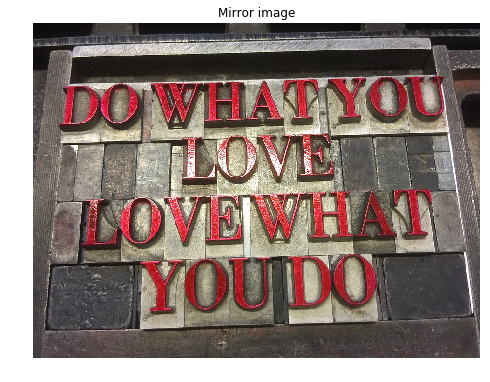

In [11]:
plt.figure(figsize=(8,8))
plt.imshow(imgMirror)
plt.axis('off')
plt.title('Mirror image')

Let's rotate the image to our preference and display it. 

## Sizing

Part of preprocessing is resizing. For reasons we won't get into here, images in the Caffe2 pipeline should be square. Also, to help with performance, they should be resized to a standard height and width which is usually going to be smaller than your original source.

In the example below we're resizing to 256 x 256 pixels, however you might notice that the `input_height` and `input_width` is set to 224 x 224 which is then used to specify the crop. You need to make sure that input images are of same size that of images that were used to train the model. 

** Make sure you double-check the input sizes for the model you're using!**

Model is expecting 224 x 224, so resize or crop needed. First, let's **resize the image to 256*256px** and crop the center of the image to 224 X 224. Finally, plot lot the image for comparision

**Note:**
- **Cropping** is when you cut off part of an image to achieve a new size or shape.
- **Resizing** maintains the entire image and simply changes the size

Original image's shape is 683x1024
Model's input shape is 224x224
New image shape:(256, 256, 3)


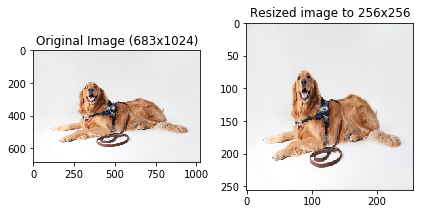

In [12]:
orig_height, orig_width, _ = img.shape
print("Original image's shape is {}x{}".format(orig_height, orig_width))
input_height, input_width = 224, 224
print("Model's input shape is {}x{}".format(input_height, input_width))
img256 = skimage.transform.resize(img, (256, 256))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img)
axarr[0].set_title("Original Image (" + str(orig_height) + "x" + str(orig_width) + ")")
axarr[0].axis('on')
axarr[1].imshow(img256)
axarr[1].axis('on')
axarr[1].set_title('Resized image to 256x256')
plt.tight_layout()

print("New image shape:" + str(img256.shape))

**Note:** The resizing has distorted the image a little bit. It is important to recognize this effect during your processing as it can have an effect on the results of your model. Flowers and animals might be ok with a little stretching or squeezing, but facial features may not. 

This can happen when the dimensions of the original image are not proportionally exact to your desired size. In this particular example it would have been better to just resize to 224x224 and not bother cropping. Let's try another strategy of rescaling the image and maintaining the aspect ratio.

### Rescaling

TO prevent distortion of the image while resizing, you need to take care of the aspect ratio while resizing. Make sure that you retain the original aspect ratio.

**aspect ratio = original width ÷ original height**

- **Landscape**: limit resize by the height
- **Portrait**: limit resize by the width

In [13]:
print("Original image shape:" + str(img.shape) + " and remember it should be in H, W, C!")
print("Model's input shape is {}x{}".format(input_height, input_width))
aspect = img.shape[1]/float(img.shape[0])
print("Orginal aspect ratio: " + str(aspect))

Original image shape:(683, 1024, 3) and remember it should be in H, W, C!
Model's input shape is 224x224
Orginal aspect ratio: 1.499267935578331


**Checking if** the image is in **Landscape** mode or **Portrait** mode and the special case where the image has the aspect ratio of "1" i.e. image_width is same as image_height. Resize the image according the orientation of the image. 

New image shape:(224, 335, 3) in HWC


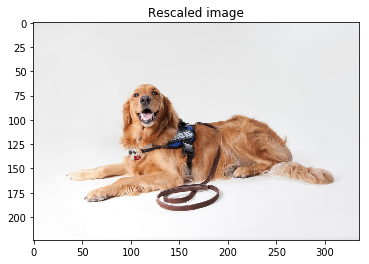

In [14]:
if(aspect>1):
    res = int(aspect * input_height)
    imgScaled = skimage.transform.resize(img, (input_height, res))
if(aspect<1):
    res = int(input_width/aspect)
    imgScaled = skimage.transform.resize(img, (res, input_width))
if(aspect == 1):
    imgScaled = skimage.transform.resize(img, (input_height, input_width))
plt.figure()
plt.imshow(imgScaled)
plt.axis('on')
plt.title('Rescaled image')
print("New image shape:" + str(imgScaled.shape) + " in HWC")

### Cropping

At this point only one dimension is set to what the model's input requires. We still need to crop one side to make a square. 

There are a variety of strategies we could utilize. 
Below we'll try a few strategies for cropping:

1. Just grab the exact dimensions you need from the middle!
2. Resize to a square that's pretty close then grab from the middle.
3. Use the rescaled image and grab the middle.


Let's compare the image cropping strategies 

Define a method to crop the image from center.

In [15]:
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

**Let's run the method on the original image and look at it! **

Original image shape:(683, 1024, 3) and remember it should be in H, W, C!


Text(0.5,1,'Original')

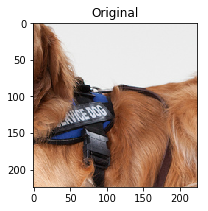

In [16]:
plt.figure(figsize=(10,10))
print("Original image shape:" + str(img.shape) + " and remember it should be in H, W, C!")
imgCenter = crop_center(img,224,224)
plt.subplot(1,3,1)
plt.imshow(imgCenter)
plt.axis('on')
plt.title('Original')

**Now, let's see what this does on the distorted image i.e. on the image that was resized without maintaining the aspect ratio. Let's call it 'Squeezed'!**

Text(0.5,1,'Squeezed')

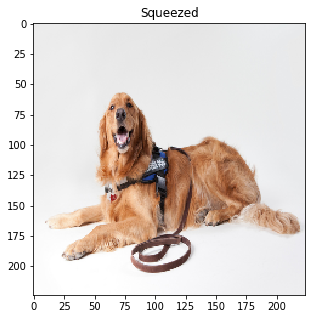

In [17]:
img256Center = crop_center(img256,224,224)
plt.figure(figsize=(5,5))
plt.imshow(img256Center)
plt.axis('on')
plt.title('Squeezed')

**Let's run the crop method on the resized the image with the aspect ratio in the mind.**

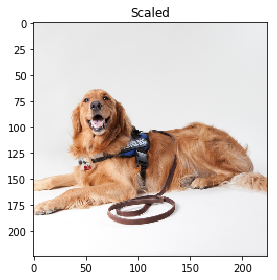

In [18]:
imgScaledCenter = crop_center(imgScaled,224,224)
plt.imshow(imgScaledCenter)
plt.axis('on')
plt.title('Scaled')

plt.tight_layout()

**Let's print out the images side by side for better comparision.**

First image - the original image 

In [ ]:
plt.figure(figsize=(12,12))
print("Original image shape:" + str(img.shape) + " and remember it should be in H, W, C!")
imgCenter = crop_center(img,224,224)
plt.subplot(1,3,1)
plt.imshow(imgCenter)
plt.axis('on')
plt.title('Original')

 The squeezed  - one without the aspect ratio.

In [ ]:
img256Center = crop_center(img256,224,224)
plt.subplot(1,3,2)
plt.imshow(img256Center)
plt.axis('on')
plt.title('Squeezed')

The Scaled - One resized and cropped with everything in mind.

In [ ]:
imgScaledCenter = crop_center(imgScaled,224,224)
plt.subplot(1,3,3)
plt.imshow(imgScaledCenter)
plt.axis('on')
plt.title('Scaled')

plt.tight_layout()

The dog image doesn't show much difference in the above tranformation. Let's take another image and play with it . 
This time **image is of Paracomandos and it is loaded from wikipedia URL.**

In [20]:
IMAGE_LOCATION_FROM_URL = "https://upload.wikimedia.org/wikipedia/commons/2/24/India_Para.jpg"

Original image shape:(2214, 3000, 3) and remember it should be in H, W, C!
Model's input shape is 224x224
Orginal aspect ratio: 1.3550135501355014
original image looks like this:


Text(0.5,1,'Para Commandos')

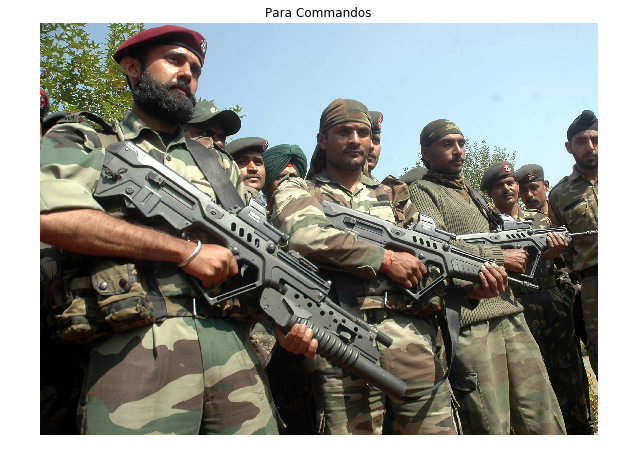

In [21]:
img = skimage.io.imread(IMAGE_LOCATION_FROM_URL)
img = skimage.img_as_float(img).astype(np.float32)
print("Original image shape:" + str(img.shape) + " and remember it should be in H, W, C!")
print("Model's input shape is {}x{}".format(input_height, input_width))
aspect = img.shape[1]/float(img.shape[0])
print("Orginal aspect ratio: " + str(aspect))
print("original image looks like this:")

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Para Commandos')

In [22]:
if(aspect>1):
    res = int(aspect * input_height)
    imgScaled = skimage.transform.resize(img, (input_height, res))
if(aspect<1):
    res = int(input_width/aspect)
    imgScaled = skimage.transform.resize(img, (res, input_width))
if(aspect == 1):
    imgScaled = skimage.transform.resize(img, (input_height, input_width))

Original image shape:(2214, 3000, 3) and remember it should be in H, W, C!


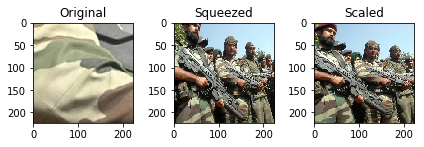

In [23]:
img256 = skimage.transform.resize(img, (256, 256))

plt.figure()
print("Original image shape:" + str(img.shape) + " and remember it should be in H, W, C!")
imgCenter = crop_center(img,224,224)
plt.subplot(1,3,1)
plt.imshow(imgCenter)
plt.axis('on')
plt.title('Original')

# The squeezed  - one without the aspect ratio.
img256Center = crop_center(img256,224,224)
plt.subplot(1,3,2)
plt.imshow(img256Center)
plt.axis('on')
plt.title('Squeezed')

# The Scaled - One resized and cropped with everything in mind. 
imgScaledCenter = crop_center(imgScaled,224,224)
plt.subplot(1,3,3)
plt.imshow(imgScaledCenter)
plt.axis('on')
plt.title('Scaled')

plt.tight_layout()

As you can see that didn't work out so well, except for maybe the last one. The middle one may be just fine too, but you won't know until you try on the model and test a lot of candidate images.
At this point we can look at the difference we have, split it in half and remove some pixels from each side. This does have a drawback, however, as an off-center subject of interest would get clipped.
If you are focusing on facial features, you need to take some extra care or else results would be error prone. 

### Upscaling

Consider a case where your images are tiny to work with.
The most basic approach is going from a small square to a bigger square and using the defauls skimage provides for you. 

Let's take an microscopic image of a Cell and resize it. Here, we are resizing it to 224 X 224 from 128X128. 

Note that it's a "PNG" image format - we'll come back to this later. 

Open the image and Load the image using sklearn  and export it as an array. 

In [24]:
imgTiny = "images/Cellsx128.png"
imgTiny = skimage.img_as_float(skimage.io.imread(imgTiny)).astype(np.float32)

Now, that we have loaded the image - Let's resize the image.  

In [25]:
imgTiny224 = skimage.transform.resize(imgTiny, (224, 224))

Check the image dimensions of the image.

In [26]:
print("Original image shape: ", imgTiny.shape)
print("Upscaled image shape: ", imgTiny224.shape)

Original image shape:  (128, 128, 4)
Upscaled image shape:  (224, 224, 4)


Let's print out the images side by side for comparision.

Text(0.5,1,'224x224')

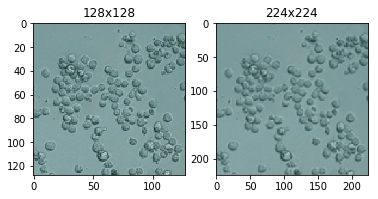

In [27]:
# Plot original
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(imgTiny)
plt.axis('on')
plt.title('128x128')
# Plot upscaled
plt.subplot(1, 2, 2)
plt.imshow(imgTiny224)
plt.axis('on')
plt.title('224x224')

Let's print out the image dimensions again - **Notice the 4 instead of 3 in the third dimesion**. 

In [28]:
print("Original image shape: ", imgTiny.shape)
print("Upscaled image shape: ", imgTiny224.shape)

Original image shape:  (128, 128, 4)
Upscaled image shape:  (224, 224, 4)


Remember? we'are using "PNG" format here.  Well, the 4th values describes **opacity, or transparency**. Depending on the assumption that you make. 

It's important to know that before we do further manipulations to the image, it's data order, and its overall payload,  you can really mess up your data and the image if you do a simple resample on the image in its current format. 

Try upscaling the image after you've switched the image to CHW.

In [29]:
imgTiny = "images/Cellsx128.png"
imgTiny = skimage.img_as_float(skimage.io.imread(imgTiny)).astype(np.float32)
print("Image shape before HWC --> CHW conversion: ", imgTiny.shape)

Image shape before HWC --> CHW conversion:  (128, 128, 4)


Switching from HWC --> CHW  and resize the image. 

In [30]:
imgTiny = imgTiny.swapaxes(1, 2).swapaxes(0, 1)
print("Image shape after HWC --> CHW conversion: ", imgTiny.shape)
imgTiny224 = skimage.transform.resize(imgTiny, (224, 224))
print("Image shape after resize: ", imgTiny224.shape)

Image shape after HWC --> CHW conversion:  (4, 128, 128)
Image shape after resize:  (224, 224, 128)


Notice the dimensions now - it's 224,224,128.  It has 128 where you should still have 4.  Let's try displaying it. 

In [31]:
try:
    plt.figure()
    plt.subplt(1, 2, 1)
    plt.imshow(imgTiny)
    plt.axis('on')
    plt.title('128x128')
except:
    print("Can't display it due to an exception!")

Can't display it due to an exception!


<Figure size 432x288 with 0 Axes>

Ok, We couldn't display it. Let's try another way - Resize the image before changing it to CHW from HWC. Let's load the image again since, we have lost the original image after so many manipulations.

In [32]:
imgTiny = skimage.io.imread("images/Cellsx128.png")
imgTiny = skimage.img_as_float(imgTiny).astype(np.float32)

Let's display the image first.

Text(0.5,1,'Original')

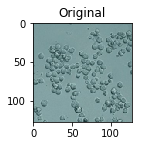

In [33]:
# Plot original
plt.figure()
plt.subplot(2, 1, 1)
plt.imshow(imgTiny)
plt.axis('on')
plt.title('Original')

Let's crop from the center.

In [34]:
imgTinySlice = crop_center(imgTiny, 128, 56)

Text(0.5,1,'128x56')

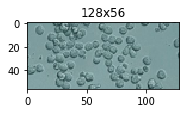

In [35]:
# Plot slice
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(imgTinySlice)
plt.axis('on')
plt.title('128x56')

Let's upscale the image and display it. It will work this time unlike the last time. 

In [36]:
print("Slice image shape: ", imgTinySlice.shape)
imgTiny224 = skimage.transform.resize(imgTinySlice, (224, 224))
print("Upscaled slice image shape: ", imgTiny224.shape)

Slice image shape:  (56, 128, 4)
Upscaled slice image shape:  (224, 224, 4)


Plot upscaled

Text(0.5,1,'224x224')

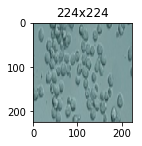

In [37]:
plt.subplot(2, 2, 2)
plt.imshow(imgTiny224)
plt.axis('on')
plt.title('224x224')

As you can see, there is a bit of **strech** in the cells above. This could be a life-or-death kind of failure though. What if normal cells are circular and diseased cells are elongated and bent? 

**What do you do when shape of cells matter like elongated ones are diseased and round ones are not!? **

In this situation, It really depends on the model and how it was trained. In some cases it may be ok to pad the rest of the image with white, or maybe black, or maybe noise, or maybe even use png and transparencies and set a mask for the images so the model ignores transparent areas. 



### Final Preprocessing and the Batch Term

Now, we have done a lot of processing. From loading the image to resizing, cropping and what not! In real life we multiples to resize and process. We need to process them in batches. 

**HWC --> CHW  to NCHW**, **N ** is the number of images in the batch. 

Here, we will add a fourth dimension (N) to the image to track the number of images. In theory, you can just keep adding dimensions to your data, but this one is required for Caffe2 as it relays to Caffe how many images to expect in this batch. 

We set it to one (1) to indicate there's only one image going into Caffe in this batch. Note that in the final output when we check `img.shape` the order is quite different. We've added N for number of images, and changed the order like so: `N, C, H, W`

In [ ]:
imgCropped = crop_center(imgScaled,224,224)
print("Image shape before HWC --> CHW conversion: ", imgCropped.shape)
imgCropped = imgCropped.swapaxes(1, 2).swapaxes(0, 1)
print("Image shape after HWC --> CHW conversion: ", imgCropped.shape)

plt.figure()
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(imgCropped[i])
    plt.axis('off')
    plt.title('RGB channel %d' % (i+1))

Caffe uses a BGR order due to legacy OpenCV issues, so we will change RGB to BGR.

Image shape before HWC --> CHW conversion:  (224, 224, 3)
Image shape after HWC --> CHW conversion:  (3, 224, 224)
Image shape after BGR conversion:  (3, 224, 224)


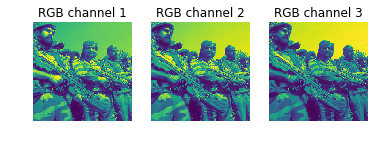

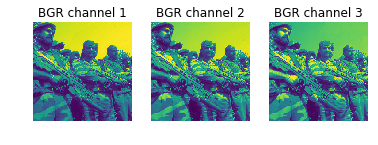

In [38]:
imgCropped = imgCropped[(2, 1, 0), :, :]
print("Image shape after BGR conversion: ", imgCropped.shape)

plt.figure()
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(imgCropped[i])
    plt.axis('off')
    plt.title('BGR channel %d' % (i+1))

 Finally, since caffe2 expect the input to have a batch term
     so we can feed in multiple images, we will simply prepend a
    batch dimension of size 1. Also, we will make sure image is
    of type np.float32.

In [39]:
imgCropped = imgCropped[np.newaxis, :, :, :].astype(np.float32)
print('Final input shape is:', imgCropped.shape)

Final input shape is: (1, 3, 224, 224)


In the output above you should note these alterations:
1. Before and after of the HWC to CHW change. The 3, which is the number of color channels moved to the beginning.
2. In the pictures above you can see that the color order was switched too. RGB became BGR. Blue and Red switched places.
3. The final input shape, meaning the last change to the image was to add the batch field to the beginning, so that now you have (1, 3, 224, 224) for: 
    - 1 image in the batch, 
    - 3 color channels (in BGR), 
    - 224 height, 
    - 224 width.